## 1. Import the main libraries

In [ ]:
# import main ML libraries
# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

import os
import pandas as pd
import numpy as np

# For category encoding
import category_encoders as ce

# matplotlib import
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import math

# Save figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# from google.colab import drive
# drive.mount('/content/drive')

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2. Import the dataset

In [ ]:
# import the dataset
df = pd.read_csv('data_dropouts.csv', delimiter = ";")

Brief description of the dataset ([here](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) the link to it):

the dataset is created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies. The dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters.

## 3. Exploratory Analysis

In [ ]:
# Check the total number of columns, missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

We've got **4424** rows and **37** columns, with any missing value.

We've got only *int* and *float* data types among features and an object data type as our target.

Let's destinct the different variables we have. The continuous features are:
- Previous qualification (grade)
- Admission grade
- Curricular grades (1st and 2nd year's grades)
- Unemployment rate
- Inflation rate
- GDP

Other variable are discrete numerical:
- Age at enrollment
- Other curricular variable than curricular grades, like units approved, credited or with no evaluations.

The rest of variables (target included) are categorical, some of which are encoded. This is a major problem to address, because many of these features have multiple levels with which we have to deal in some way.

In total we have:
- 7 continuous variables.
- 11 discrete numerical variables.
- 18 categorical variables.
- 1 target (categorical).

Moreover, the **target** isn't binary, and this is another problem we need to address. We may choose to drop one of them, if it doesn't relate to sufficient entrances; or we can merge two of them, if we don't loose relevant informations about the phenomenon we're analysing.

Finally, we need to manipulate columns' names in order to work faster with them and correct the name of the "**Nacionality**" feature.

In [ ]:
# Rename the column Nationality
df.rename(columns={"Nacionality": "Nationality"}, inplace = True)

In [ ]:
# Let's previw the dataset
df.head(5)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Now, I will view the column names to check for leading and trailing spaces.

In [ ]:
# view the column names of the dataframe
col_names = df.columns

col_names

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nationality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd

We need to modify columns' names in order to deal more efficiently with them.

In [ ]:
# Let's remove leading and trailing spaces
df.columns = df.columns.str.strip()

# Rename the columns
df.columns = [
    'marital_status','application_mode','application_order','course_id','daytime_attendance','prev_qualification','prev_qual_grade',
    'nationality','mother_qual','father_qual','mother_occupation','father_occupation','admission_grade',
    'is_displaced','special_needs','is_debtor','fees_paid','gender','has_scholarship','age_enrollment',
    'is_international','sem1_units_credited','sem1_units_enrolled','sem1_units_eval','sem1_units_approved',
    'sem1_grade_avg','sem1_units_no_eval','sem2_units_credited','sem2_units_enrolled','sem2_units_eval',
    'sem2_units_approved','sem2_grade_avg','sem2_units_no_eval','unemployment_rate','inflation_rate','gdp','target'
]

# View the renamed columns
df.columns

Index(['marital_status', 'application_mode', 'application_order', 'course_id',
       'daytime_attendance', 'prev_qualification', 'prev_qual_grade',
       'nationality', 'mother_qual', 'father_qual', 'mother_occupation',
       'father_occupation', 'admission_grade', 'is_displaced', 'special_needs',
       'is_debtor', 'fees_paid', 'gender', 'has_scholarship', 'age_enrollment',
       'is_international', 'sem1_units_credited', 'sem1_units_enrolled',
       'sem1_units_eval', 'sem1_units_approved', 'sem1_grade_avg',
       'sem1_units_no_eval', 'sem2_units_credited', 'sem2_units_enrolled',
       'sem2_units_eval', 'sem2_units_approved', 'sem2_grade_avg',
       'sem2_units_no_eval', 'unemployment_rate', 'inflation_rate', 'gdp',
       'target'],
      dtype='object')

In [ ]:
# Let's check the distribution of our target variable
df["target"].value_counts()

,count
target,
Graduate,2209
Dropout,1421
Enrolled,794


In [ ]:
# I want to represent them as percentage
perc_target =  round((df["target"].value_counts() / np.float64(len(df))) * 100, ndigits = 2)
perc_target

,count
target,
Graduate,49.93
Dropout,32.12
Enrolled,17.95


In [ ]:
# I want to have a sense of the absolute number of enrolled instances
print((df["target"] == "Enrolled").sum())

794


In order to reduce the classification problem to a binary problem, we may consider to drop rows where the target is equal to "Enrolled". We would lost only the ≈18% of the observation without ending up with a **class imbalance problem**.

In [ ]:
# Eliminate the rows where target = "Enrolled"
df.drop(labels = df[df["target"] == "Enrolled"].index, inplace = True)

df["target"].value_counts()

,count
target,
Graduate,2209
Dropout,1421


In [ ]:
# Let's reset the index and get a sense of our data frame
df.reset_index(drop = True, inplace = True)
print(df.shape)
print(round(df["target"].value_counts() / np.float64(len(df)) * 100, ndigits = 2))

(3630, 37)
target
Graduate    60.85
Dropout     39.15
Name: count, dtype: float64


Now we have 3630 observations and 36 features plus the target.

Now we focus the analysis on the continuous and numerical discrete variables, just to get a sense of their distribution and detect possible anomalies. Our continuous variables are:
- Previous qualification (grade)
- Admission grade
- Curricular grades (1st and 2nd year's grades)
- Unemployment rate
- Inflation rate
- GDP

In [ ]:
df[["prev_qual_grade", "admission_grade", "sem1_grade_avg", "sem2_grade_avg", "unemployment_rate","inflation_rate","gdp"]].describe().round(2)

,prev_qual_grade,admission_grade,sem1_grade_avg,sem2_grade_avg,unemployment_rate,inflation_rate,gdp
count,3630.00,3630.00,3630.00,3630.00,3630.00,3630.00,3630.00
mean,132.92,127.29,10.53,10.04,11.63,1.23,-0.01
std,13.24,14.61,5.06,5.48,2.67,1.38,2.26
min,95.00,95.00,0.00,0.00,7.60,-0.80,-4.06
25%,125.00,118.00,11.00,10.52,9.40,0.30,-1.70
50%,133.10,126.50,12.34,12.33,11.10,1.40,0.32
75%,140.00,135.10,13.50,13.50,13.90,2.60,1.79
max,190.00,190.00,18.88,18.57,16.20,3.70,3.51


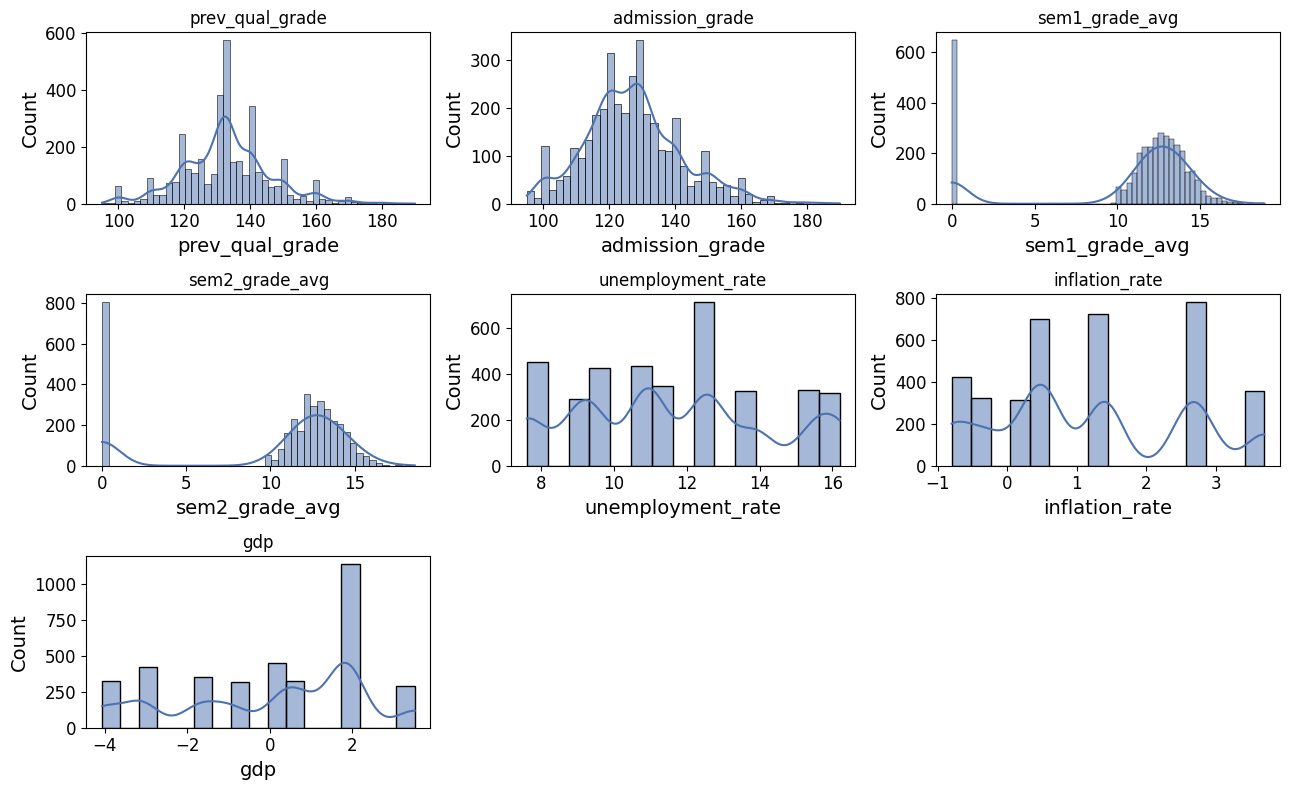

In [ ]:
# Let's plot them to get better insights

cont_cols = ["prev_qual_grade", "admission_grade", "sem1_grade_avg", "sem2_grade_avg", "unemployment_rate","inflation_rate","gdp"]

fig, axes = plt.subplots(3, 3, figsize=(13,8))
axes = axes.flatten()

for i, col in enumerate(cont_cols):
  sns.histplot(data = df, x = col, kde = True, color='#4c72b0', ax = axes[i])
  axes[i].set_title(col)

fig.delaxes(axes[7])
fig.delaxes(axes[8])

plt.tight_layout()
plt.show()

The analysis reveals three important aspects in the nature of continuous features we've plotted:

**Individual Variables**: *prev_qual_grade* and *admission_grade* exhibit continuous, Gaussian-like distributions, reflecting the natural variance in individual performance.

**Outcome Indicators**: *sem1_grade_avg* and *sem2_grade_avg* display a highly skewed, bimodal distribution. There is a massive, systemic cluster of observations concentrated near zero, followed by a secondary peak around the mean passing grade (12-14). This dense cluster near zero probably represents students who failed all units or prematurely withdrew. This structure is a direct indicator of the negative class outcome.

**Systemic Variables**: *unemployment_rate*, *inflation_rate*, and *gdp* display discrete, multimodal distributions with low cardinality.

This behavior stems from temporal granularity. Students enrolled in the same academic year share identical macroeconomic metrics; therefore, the histogram peaks represent distinct enrollment cohorts.

Reflecting on the way the model may will learn from data, we can hypotize that it will learn the impact of a specific enrollment year (proxied by its economic indicators) rather than the direct effect of economics on a specific student.

Let's now analyse the numerical discrete variables and then categorical ones. Previously we need to create two other lists of variables: one for the numerical discrete variables, and the other for categorical variables.

In [ ]:
# Let's define manually the numerical discrete features
ndiscr_cols = [
    'age_enrollment',
    'sem1_units_credited', 'sem1_units_enrolled', 'sem1_units_eval', 'sem1_units_approved', 'sem1_units_no_eval',
    'sem2_units_credited', 'sem2_units_enrolled', 'sem2_units_eval', 'sem2_units_approved', 'sem2_units_no_eval'
]

# I calculate the categorical variables by difference
cols_to_exclude = set(cont_cols + ndiscr_cols + ["target"])

# I create the list of categorical variables
cat_cols = [col for col in df.columns if col not in cols_to_exclude]

Let's check that everything is fine.

In [ ]:
# Test
print(f"Total columns: {len(df.columns)}")
print(f"Target: 1")
print(f"Continuous variables: {len(cont_cols)}")
print(f"Discrete numerical: {len(ndiscr_cols)}")
print(f"Categorical: {len(cat_cols)}")

Total columns: 37
Target: 1
Continuous variables: 7
Discrete numerical: 11
Categorical: 18


We can now start to work separately on discrete numerical variables and then on categorical ones.

In [ ]:
# We use the describe() function before, to get numerical insights on these variables
df[ndiscr_cols].describe().round(2)

,age_enrollment,sem1_units_credited,sem1_units_enrolled,sem1_units_eval,sem1_units_approved,sem1_units_no_eval,sem2_units_credited,sem2_units_enrolled,sem2_units_eval,sem2_units_approved,sem2_units_no_eval
count,3630.00,3630.00,3630.00,3630.00,3630.00,3630.00,3630.00,3630.00,3630.00,3630.00,3630.00
mean,23.46,0.75,6.34,8.07,4.79,0.13,0.58,6.30,7.76,4.52,0.14
std,7.83,2.48,2.57,4.29,3.24,0.68,2.02,2.26,3.96,3.16,0.75
min,17.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,5.00,6.00,3.00,0.00,0.00,5.00,6.00,2.00,0.00
50%,20.00,0.00,6.00,8.00,5.00,0.00,0.00,6.00,8.00,5.00,0.00
75%,25.00,0.00,7.00,10.00,6.00,0.00,0.00,7.00,10.00,6.00,0.00
max,70.00,20.00,26.00,45.00,26.00,12.00,19.00,23.00,33.00,20.00,12.00


[Results descriptions...]

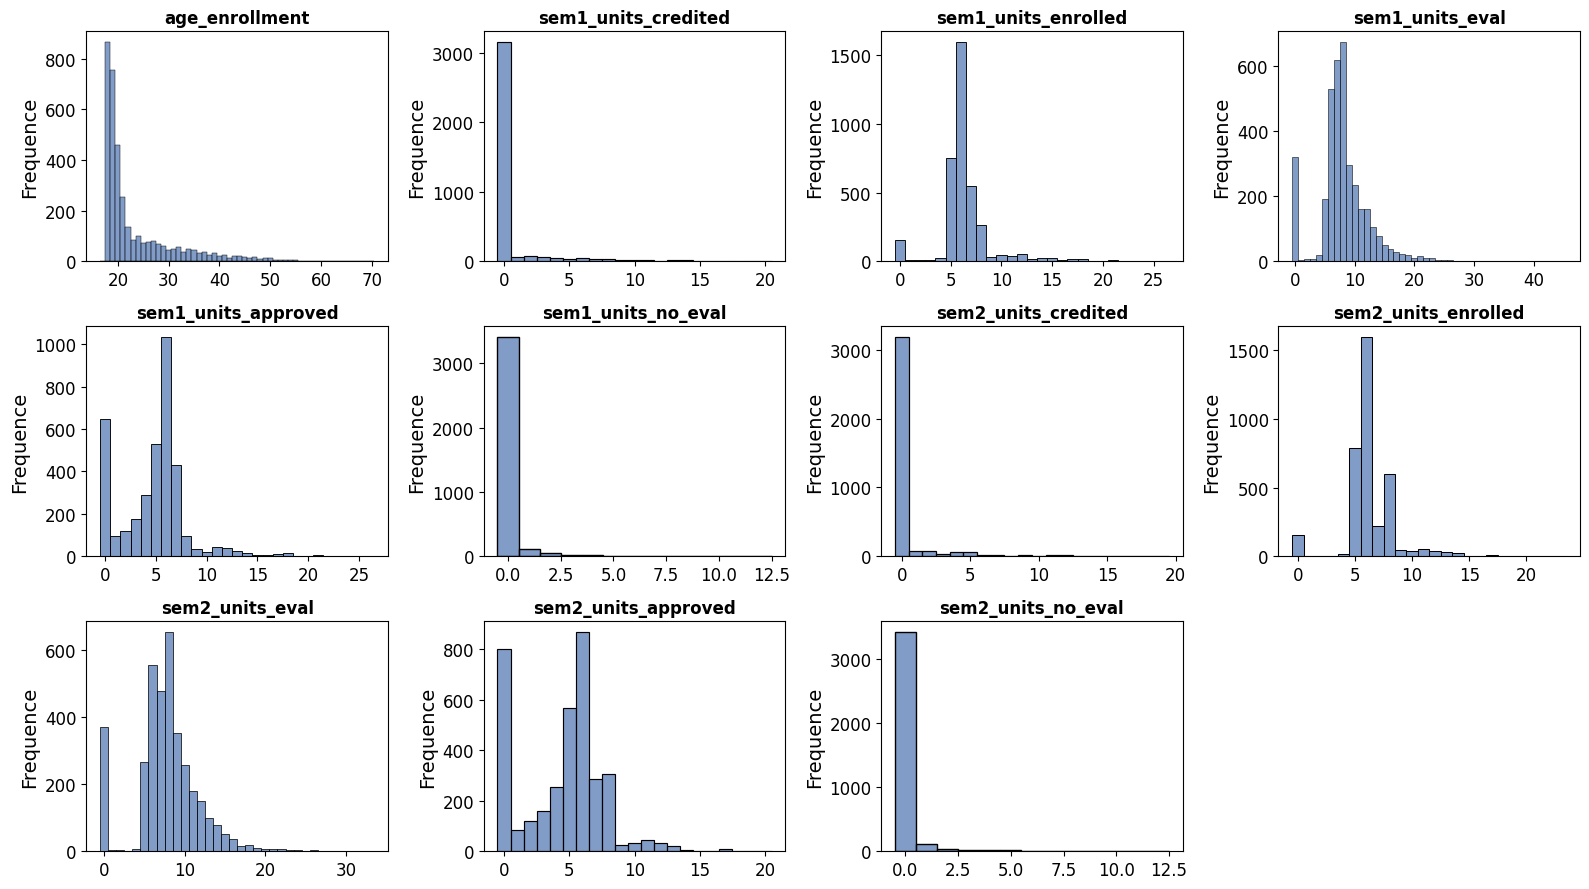

In [ ]:
# Let's plot them

n_cols = 4
n_rows = math.ceil(len(ndiscr_cols) / n_cols)
plt.figure(figsize=(16, 9))

for i, col in enumerate(ndiscr_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)

    sns.histplot(data=df, x=col, discrete=True, kde=False, color='#4c72b0', alpha=0.7, ax=ax)

    ax.set_title(col, fontsize=12, fontweight='bold')
    ax.set_xlabel(None)
    ax.set_ylabel("Frequence")

plt.tight_layout()
plt.show()

Most enrollment and performance features follow a unimodal - or bimodal for `sem1_units_approved` and `sem2_units_approved`- with an evident right skew (especially age_enrollment).

Several variables are zero-inflated (e.g. `units_credited` and `units_no_eval`), aspect that may lead to think to drop them. This would be an error, because for the observation different from zero these variables may function as powerfull predictors. For example We can hypothesize that a significant portion of dropouts are students with `sem1_units_no_eval > 0`. This means they are enrolled in courses but did not receive an evaluation. We can term this phenomenon *Passive Academic Ghosting*. If validated, this feature will be an important predictor for our dropout model.

Let's analyze the target distribution for students with `sem1_units_no_eval > 0`:

In [ ]:
# We select rows where "sem1_units_no_eval" > 0 and count values of the target for those rows:
df[df["sem1_units_no_eval"] > 0]["target"].value_counts(normalize=True)

,proportion
target,
Dropout,0.553571
Graduate,0.446429


In [ ]:
# We need to confront the value 0.55 with the total rate of dropouts in order to evaluate its significance:
df["target"].value_counts(normalize=True)

,proportion
target,
Graduate,0.60854
Dropout,0.39146


Given the sharp contrast between the specific and global dropout rates (0.55 vs. 0.39), we expect this feature to be a critical predictor, confirming what we have supposed before about sparse features.

Furthermore, analyzing `sem1_units_enrolled` and `sem1_units_approved` merely as absolute values limits our interpretability. To capture true academic engagement, we should evaluate the ratio between these variables, quantifying how many units a student successfully completed relative to their initial study plan. We may create a new variable called `approval_rate` in which we capture this relationship. This may lead to a collinearity issue, since the variable will be correlated with the other two. This would be a problem at least in two different scenario:
- In an OLS framework, since this model suffer multicollinearity in coefficients estimation.
- In an inference framework, in which we may be interested to distinguish the more important features.

Given that we're in a classification framework where what we care for is the predictive performance of the model, we can try to create the variable and implement the model with no elimination of collinear features.

Another problem may arise: by creating two new variables (one for the first semester and the other for the second) we're increasing the dimensionality of our dataset, something we need to avoid with SVM (it leads to estimation inefficiences). I don't think we'll end up with too many dimensions, so I want to try this path.

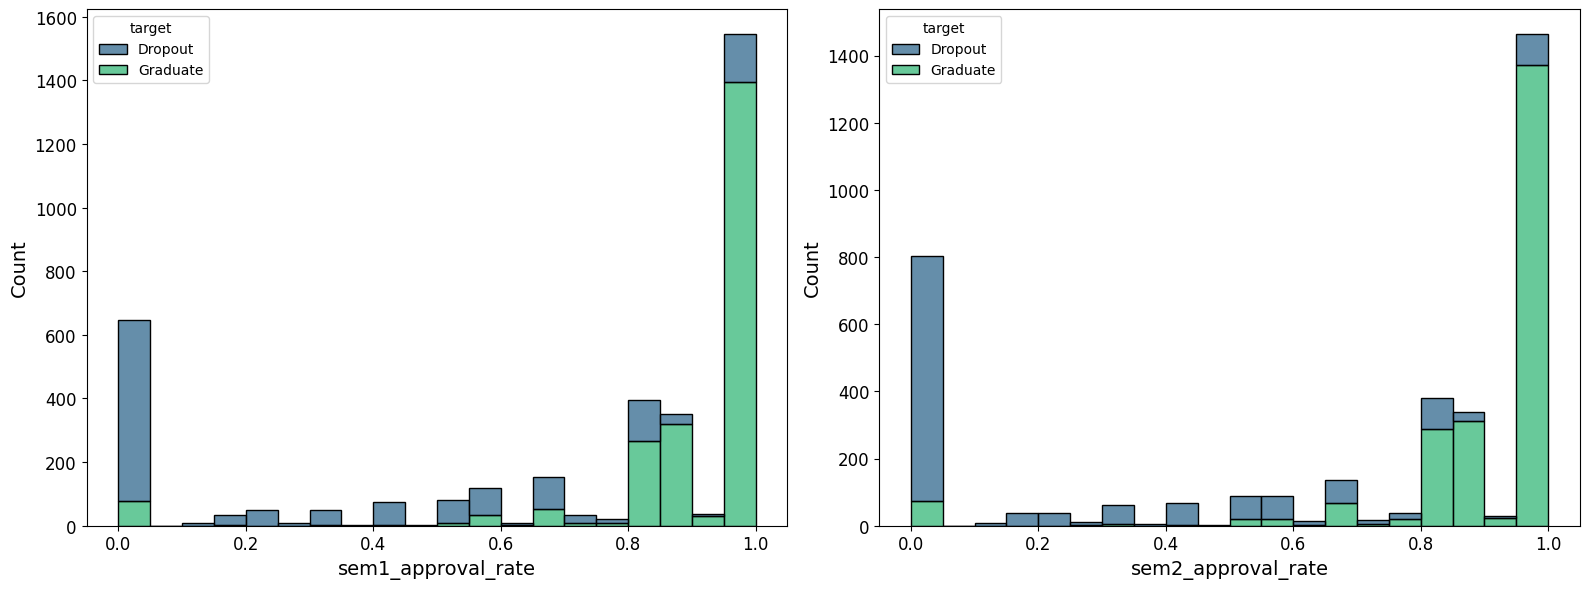

In [ ]:
# We create two new variables called "sem1_approval_rate" and "sem2_approval_rate"
df["sem1_approval_rate"] = df["sem1_units_approved"] / df["sem1_units_enrolled" ]
df["sem2_approval_rate"] = df["sem2_units_approved"] / df["sem2_units_enrolled" ]

# We add them to the list of continuous variables
cont_cols.extend(["sem1_approval_rate", "sem2_approval_rate"])

# Remove eventual NaN
df["sem1_approval_rate"] = df["sem1_approval_rate"].fillna(0)
df["sem2_approval_rate"] = df["sem2_approval_rate"].fillna(0)

# Remove eventual inf
df.replace([np.inf, -np.inf], 0, inplace=True)

# let's plot them against the target to see if there's a correlation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sem 1
sns.histplot(data=df, x="sem1_approval_rate", hue="target", multiple="stack", bins=20, palette="viridis", ax=axes[0])

# Sem 2
sns.histplot(data=df, x="sem2_approval_rate", hue="target", multiple="stack", bins=20, palette="viridis", ax=axes[1])

plt.tight_layout()
plt.show()

These graphs make vary clear that lower is the approval rate, higher will be the chance of dropout for a student. This will be probably another powerfull predictor for our model. Wa can check this later by some features importance test.

Now we can test in general if there is correlation between numerical features and our target by creating a correlation matrix - we include also the continuous variables.

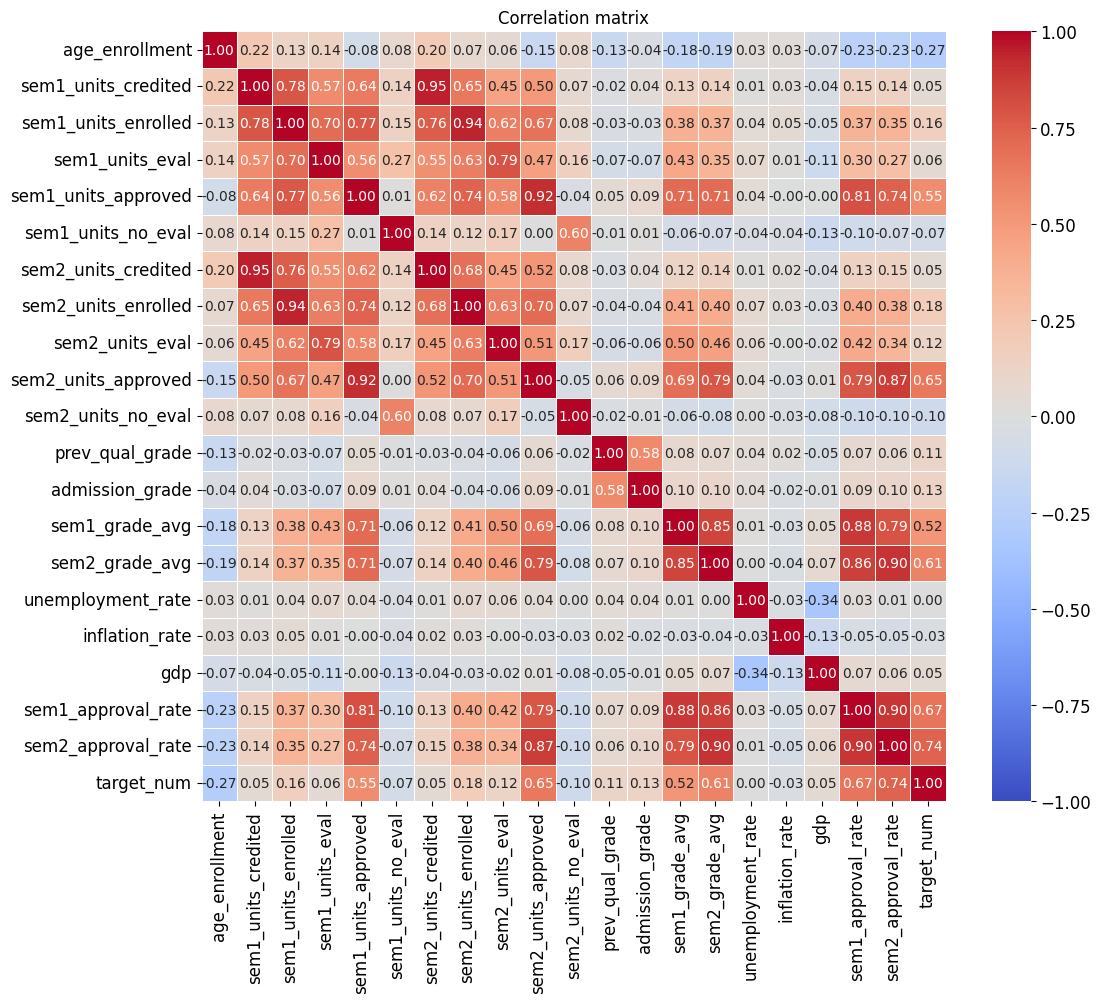

In [ ]:
# We need to convert the target in numerical. For doing this we create a copy of the dataframe
df_corr = df.copy()
df_corr["target_num"] = df_corr["target"].map({'Dropout': 0, 'Graduate': 1})

# Let's create the list of numerical features + target
cols_heat = ndiscr_cols + cont_cols + ["target_num"]

# Create the correlation matrix
corr_matrix = df_corr[cols_heat].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1, vmax=1,
            linewidths=0.5)

plt.title("Correlation matrix")
plt.show()


We can derive some relevant insights from this correlation matrix:

- We can see that the variables with higher correlation with the target are the ones relative to the students' performance (`sem1_units_approved`, `sem2_units_approved`, `sem1_grade_avg`, `sem2_grade_avg`, `sem1_approval_rate`, `sem2_approval_rate`). Furthermore, the two features we've created (`sem1_approval_rate`, `sem2_approval_rate`) present a higher correlation than the others. This suggests that the feature-engineering choice may be correct.

- We can notice a strong positive correlation between the same features of different semesters. This means that they tend to carry the same information to the model. We may opt for eliminating one of the two semesters (this may improve the interpretability of the model and decrease the dimensionality) and create a new variable (`delta`) that captures the improvement (or setback) of students (`sem2` - `sem1`).

- The last important thing to notice is that continuous variables present coefficients close to zero. This may be naively interpreted as a weak relation with the target. But we need to keep in mind that correlation measures the linear relationship between two variables; in this case, we may have a non-linear relationship between them, so it's correct to keep them in our model.

Now we proceed to the analysis of categorical features.

In [ ]:
# Let's recall the categorical features and check their dimension
print(len(cat_cols), cat_cols)

18 ['marital_status', 'application_mode', 'application_order', 'course_id', 'daytime_attendance', 'prev_qualification', 'nationality', 'mother_qual', 'father_qual', 'mother_occupation', 'father_occupation', 'is_displaced', 'special_needs', 'is_debtor', 'fees_paid', 'gender', 'has_scholarship', 'is_international']


We've got 18 categorical features of which we want analyse the structure and composition. In particular, we're interested in:
- How many levels thay have.
- Which one of these levels are more representative.

In [ ]:
# Let's print the informations. We want to check for the rate and the absolute frequency of each level

for col in cat_cols:
  print(f"--{col.upper()}--")
  print(f"levels: {df[col].nunique()}")
  print(df[col].value_counts(normalize = True).round(3) * 100)
  print(df[col].value_counts())
  print("\n")

--MARITAL_STATUS--
levels: 6
marital_status
1    88.1
2     9.0
4     2.1
5     0.6
6     0.1
3     0.1
Name: proportion, dtype: float64
marital_status
1    3199
2     327
4      75
5      22
6       5
3       2
Name: count, dtype: int64


--APPLICATION_MODE--
levels: 18
application_mode
1     38.8
17    19.6
39    18.3
43     6.5
44     4.3
7      3.6
18     3.0
42     1.8
51     1.3
16     0.8
53     0.7
15     0.6
10     0.3
5      0.2
2      0.1
57     0.0
26     0.0
27     0.0
Name: proportion, dtype: float64
application_mode
1     1408
17     713
39     664
43     237
44     157
7      132
18     108
42      66
51      46
16      30
53      25
15      20
10      10
5        8
2        3
57       1
26       1
27       1
Name: count, dtype: int64


--APPLICATION_ORDER--
levels: 7
application_order
1    67.8
2    12.4
3     6.9
4     6.0
5     3.6
6     3.3
0     0.0
Name: proportion, dtype: float64
application_order
1    2461
2     451
3     249
4     218
5     129
6     121
0     

Let's breakdown the results:
- `marital_status`: here we can group the last three less representative levels (30 obs in total may be just noise and they may lead the model to overfitting). We go for binning the last three levels and proceed with a one-hot encoding for the feature.


In [ ]:
# Let's first create a function that groups levels

def group_levels(df, col, threshold=25):

  # count frequencies
  counts = df[col].value_counts()

  # find levels
  to_group = counts[counts < threshold].index

  # replace
  df[col] = df[col].replace(to_group, "Other")

  return df

# Apply to marital_status
group_levels(df, "marital_status")
print(df["marital_status"].value_counts())

marital_status
1        3199
2         327
4          75
Other      29
Name: count, dtype: int64


In [ ]:
# One-hot encoding of marital_status
df_encoded = pd.get_dummies(df, columns=["marital_status"], drop_first=True)
print(df_encoded.columns)

Index(['application_mode', 'application_order', 'course_id',
       'daytime_attendance', 'prev_qualification', 'prev_qual_grade',
       'nationality', 'mother_qual', 'father_qual', 'mother_occupation',
       'father_occupation', 'admission_grade', 'is_displaced', 'special_needs',
       'is_debtor', 'fees_paid', 'gender', 'has_scholarship', 'age_enrollment',
       'is_international', 'sem1_units_credited', 'sem1_units_enrolled',
       'sem1_units_eval', 'sem1_units_approved', 'sem1_grade_avg',
       'sem1_units_no_eval', 'sem2_units_credited', 'sem2_units_enrolled',
       'sem2_units_eval', 'sem2_units_approved', 'sem2_grade_avg',
       'sem2_units_no_eval', 'unemployment_rate', 'inflation_rate', 'gdp',
       'target', 'sem1_approval_rate', 'sem2_approval_rate',
       'marital_status_2', 'marital_status_4', 'marital_status_Other'],
      dtype='object')


- `application_mode`: this is a feature with high cardinality respect to the first. We've got the last 9 levels that in total represent the 2.7% of the observations. Here we may group these 9 levels and opt for a binary encoding. This approach let us control the dimensionality, but has the price of reduce the interpretability of the model (it reduce the number of represented levels). Given the prediction context we can opt for the efficiency of the model rather than its interpretability.

In [ ]:
# Let's binning application_mode

group_levels(df, "application_mode", 35)
print(df["application_mode"].value_counts())

application_mode
1        1408
17        713
39        664
43        237
44        157
7         132
18        108
Other      99
42         66
51         46
Name: count, dtype: int64


In [ ]:
# Than we do binary encoding of application_mode. We should end up with 4 columns (log2(10) = 3.32 round up to 4)
binary_encoder = ce.BinaryEncoder(cols=["application_mode"])
df = binary_encoder.fit_transform(df)

print(df.columns)

Index(['marital_status', 'application_mode_0', 'application_mode_1',
       'application_mode_2', 'application_mode_3', 'application_order',
       'course_id', 'daytime_attendance', 'prev_qualification',
       'prev_qual_grade', 'nationality', 'mother_qual', 'father_qual',
       'mother_occupation', 'father_occupation', 'admission_grade',
       'is_displaced', 'special_needs', 'is_debtor', 'fees_paid', 'gender',
       'has_scholarship', 'age_enrollment', 'is_international',
       'sem1_units_credited', 'sem1_units_enrolled', 'sem1_units_eval',
       'sem1_units_approved', 'sem1_grade_avg', 'sem1_units_no_eval',
       'sem2_units_credited', 'sem2_units_enrolled', 'sem2_units_eval',
       'sem2_units_approved', 'sem2_grade_avg', 'sem2_units_no_eval',
       'unemployment_rate', 'inflation_rate', 'gdp', 'target',
       'sem1_approval_rate', 'sem2_approval_rate'],
      dtype='object')


- `application_order`: here we can remove the observation with level zero; another important thing is that this is an ordinal variable and we want to preserve the information about the importance of choice. Since the levels of this features are already numerical ordinal, we can leave it as it is.

In [ ]:
# TODO
# Finish binning and encoding of categorical variables
# Transformation (?)
# OLS
# SVM
# Random forest